# Capstone Project - The Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted for people that are new to Hyderabad,it can be daunting to figure out what restaurants are worth going to and where they are and for the stakeholders interested in opening a restaurant in Hyderabad, India.

Since there are lots of restaurants in Hyderabad we will try to detect locations that are that are with good likes. We would also prefer locations as close to city center as possible.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria.

## Data <a name="data"></a>

For this assignment, I will be utilizing the Foursquare API to pull the following location data on restaurants in Hyderabad, IND.

1. Venue Name
2. Venue ID
3. Venue Location
4. Venue Category
5. Count of Likes

To acquire the data mentioned above, I will need to do the following:

Get geolocator lat and long coordinates for Hyderabad,IND. Use Foursquare API to get a list of all venues in Hyderabad

--> Get venue name, venue ID, location, category, and likes

# Data Preparation and Pull

In [49]:
# importing libraries

import requests
import pandas as pd
import numpy as np
import random
import folium
from geopy.geocoders import Nominatim
import re

#from Ipython.display import Image
#from Ipython.core.display import HTML

from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print("imported libraries")

imported libraries


In [50]:
# define API Credentials and get geographical Coordinates
#API Credentials
CLIENT_ID = '2GY2DGZ2WOXNNKBHZIDRTCTVLHYZJGY2214GF4O1WPMWXDHC' # your Foursquare ID
CLIENT_SECRET = 'SE1DCOXXYGQOULSZ2VEPYAV0SJ2JRNUNWGBDOEMD1XXUF0KA' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 1000

# Get latitude and longitude
address = 'Hyderabad'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Latitude is {} and Longitude is {}".format(latitude,longitude))

#location = geolocator.reverse("{} {}".format(latitude, longitude))
#print(location.address)


Latitude is 17.38878595 and Longitude is 78.4610647345315


In [51]:
# define search query and 
# search query
search_query = 'restaurant'
radius = 10000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
#print(results)
venues=results['response']['venues']
df = json_normalize(venues)
df.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",False,4f9433d3e4b0949d21694780,Adj. Prince Hotel,IN,Hyderabad,India,Meraj Hotel,2076,"[Adj. Prince Hotel (Meraj Hotel), Hyderabad 50...","[{'label': 'display', 'lat': 17.39448615049604...",17.394486,78.442452,500028,Telangana,Akbar Fast Food Restaurant,v-1571381623
1,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",False,4c81163ad92ea093375a3d72,Toli Chowli,IN,Hyderabad,India,M,3911,"[Toli Chowli (M), Hyderabad 500058, Telangana,...","[{'label': 'display', 'lat': 17.3962770409263,...",17.396277,78.425094,500058,Telangana,Shah Ghouse Cafe and Restaurant,v-1571381623
2,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",False,517bee0be4b055745975c517,NaN,IN,NaN,India,NaN,3109,[India],"[{'label': 'display', 'lat': 17.39536160730009...",17.395362,78.432614,NaN,NaN,Al Rabea Al Arabi Restaurant,v-1571381623
3,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,50d1b77ee4b0d5316b4e0bff,Darus Salaam,IN,Hyderabad,India,NaN,853,"[Darus Salaam, Hyderabad, Telangana, India]","[{'label': 'display', 'lat': 17.38261412350797...",17.382614,78.465828,NaN,Telangana,Voulga Restaurant,v-1571381623
4,"[{'id': '54135bf5e4b08f3d2429dfe6', 'name': 'H...",False,4bcee9d1cc8cd13a5efdc4cf,Paradise Circle,IN,Secunderabad,India,NaN,6533,"[Paradise Circle, Secunderabad 500003, Telanga...","[{'label': 'display', 'lat': 17.44184420016073...",17.441844,78.487354,500003,Telangana,Paradise Restaurant,v-1571381623


In [52]:
df.describe()

,location.distance,location.lat,location.lng
count,50.000000,50.000000,50.000000
mean,2466.700000,17.398982,78.460555
std,1631.713138,0.013660,0.021557
min,541.000000,17.365207,78.386887
25%,1601.750000,17.391144,78.453218
50%,2045.000000,17.399734,78.464242
75%,2598.500000,17.404715,78.475278
max,7994.000000,17.441844,78.496268


In [53]:
# keep only columns that include venue name, and anything that is associated with location
fil_col = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
df_fil = df.loc[:, fil_col]
df_fil
#fil_col

,name,categories,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,id
0,Akbar Fast Food Restaurant,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",Adj. Prince Hotel,IN,Hyderabad,India,Meraj Hotel,2076,"[Adj. Prince Hotel (Meraj Hotel), Hyderabad 50...","[{'label': 'display', 'lat': 17.39448615049604...",17.394486,78.442452,500028,Telangana,4f9433d3e4b0949d21694780
1,Shah Ghouse Cafe and Restaurant,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",Toli Chowli,IN,Hyderabad,India,M,3911,"[Toli Chowli (M), Hyderabad 500058, Telangana,...","[{'label': 'display', 'lat': 17.3962770409263,...",17.396277,78.425094,500058,Telangana,4c81163ad92ea093375a3d72
2,Al Rabea Al Arabi Restaurant,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",NaN,IN,NaN,India,NaN,3109,[India],"[{'label': 'display', 'lat': 17.39536160730009...",17.395362,78.432614,NaN,NaN,517bee0be4b055745975c517
3,Voulga Restaurant,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",Darus Salaam,IN,Hyderabad,India,NaN,853,"[Darus Salaam, Hyderabad, Telangana, India]","[{'label': 'display', 'lat': 17.38261412350797...",17.382614,78.465828,NaN,Telangana,50d1b77ee4b0d5316b4e0bff
4,Paradise Restaurant,"[{'id': '54135bf5e4b08f3d2429dfe6', 'name': 'H...",Paradise Circle,IN,Secunderabad,India,NaN,6533,"[Paradise Circle, Secunderabad 500003, Telanga...","[{'label': 'display', 'lat': 17.44184420016073...",17.441844,78.487354,500003,Telangana,4bcee9d1cc8cd13a5efdc4cf
5,Nimrah Restaurant And Bakery,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",NaN,IN,Hyderabad,India,NaN,866,"[Hyderabad 500004, TG, India]","[{'label': 'display', 'lat': 17.392616, 'lng':...",17.392616,78.468165,500004,TG,5a21602775a6ea748fd77429
6,Grills restaurant,"[{'id': '503287a291d4c4b30a586d65', 'name': 'F...",NaN,IN,Hyderabad,India,NaN,541,"[Hyderabad, Telangana, India]","[{'label': 'display', 'lat': 17.38612646647625...",17.386126,78.456796,NaN,Telangana,5823557cda82023188157a2f
7,Zoha Restaurant,"[{'id': '54135bf5e4b08f3d2429dfe6', 'name': 'H...",NaN,IN,NaN,India,NaN,598,[India],"[{'label': 'display', 'lat': 17.393055, 'lng':...",17.393055,78.457642,NaN,NaN,5686bc36498ece24b0f97da8
8,Sri Anupama Family Restaurant,"[{'id': '54135bf5e4b08f3d2429dfe5', 'name': 'A...","Ahmed Commercial Complex, Ameerpet Main Road, ...",IN,Hyderabad,India,"Nagarjuna Nagar Colony, Yella Reddy Guda",709,"[Ahmed Commercial Complex, Ameerpet Main Road,...","[{'label': 'display', 'lat': 17.38475703996001...",17.384757,78.455890,500073,Telangana,5a1ade2ae96d0c5d8b3dc3da
9,Woodland Restaurant,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",NaN,IN,NaN,India,NaN,3022,[India],"[{'label': 'display', 'lat': 17.40213821121375...",17.402138,78.485842,NaN,NaN,4eb54b825c5c5a531ff0d6cd


In [54]:
# filter category values 
cat=[]
for i in range(0,len(df_fil['categories'])):
    try:
        cat.append(df['categories'][i][0]['name'])
    except:
        cat.append(None)

for i in range(0,len(df['categories'])):
    if cat[i]==None : cat[i]=df['name'][i]
        
df_fil.drop(['categories'],axis=1)
df_fil['categories']=cat

In [55]:

df_fil=df_fil.drop(['location.labeledLatLngs', 'location.cc'], axis=1)

'''
for col in df_fil.columns:
    if col.startswith('location.'):
        n_c=re.findall(r'\w+$',col)[0]
        df_fil=df_fil.rename({col:n_c}, axis=1)'''

df_fil.columns = [col.split(".")[-1] for col in df_fil.columns]

df_fil


,name,categories,address,city,country,crossStreet,distance,formattedAddress,lat,lng,postalCode,state,id
0,Akbar Fast Food Restaurant,Indian Restaurant,Adj. Prince Hotel,Hyderabad,India,Meraj Hotel,2076,"[Adj. Prince Hotel (Meraj Hotel), Hyderabad 50...",17.394486,78.442452,500028,Telangana,4f9433d3e4b0949d21694780
1,Shah Ghouse Cafe and Restaurant,Indian Restaurant,Toli Chowli,Hyderabad,India,M,3911,"[Toli Chowli (M), Hyderabad 500058, Telangana,...",17.396277,78.425094,500058,Telangana,4c81163ad92ea093375a3d72
2,Al Rabea Al Arabi Restaurant,Middle Eastern Restaurant,NaN,NaN,India,NaN,3109,[India],17.395362,78.432614,NaN,NaN,517bee0be4b055745975c517
3,Voulga Restaurant,Restaurant,Darus Salaam,Hyderabad,India,NaN,853,"[Darus Salaam, Hyderabad, Telangana, India]",17.382614,78.465828,NaN,Telangana,50d1b77ee4b0d5316b4e0bff
4,Paradise Restaurant,Hyderabadi Restaurant,Paradise Circle,Secunderabad,India,NaN,6533,"[Paradise Circle, Secunderabad 500003, Telanga...",17.441844,78.487354,500003,Telangana,4bcee9d1cc8cd13a5efdc4cf
5,Nimrah Restaurant And Bakery,Restaurant,NaN,Hyderabad,India,NaN,866,"[Hyderabad 500004, TG, India]",17.392616,78.468165,500004,TG,5a21602775a6ea748fd77429
6,Grills restaurant,Financial or Legal Service,NaN,Hyderabad,India,NaN,541,"[Hyderabad, Telangana, India]",17.386126,78.456796,NaN,Telangana,5823557cda82023188157a2f
7,Zoha Restaurant,Hyderabadi Restaurant,NaN,NaN,India,NaN,598,[India],17.393055,78.457642,NaN,NaN,5686bc36498ece24b0f97da8
8,Sri Anupama Family Restaurant,Andhra Restaurant,"Ahmed Commercial Complex, Ameerpet Main Road, ...",Hyderabad,India,"Nagarjuna Nagar Colony, Yella Reddy Guda",709,"[Ahmed Commercial Complex, Ameerpet Main Road,...",17.384757,78.455890,500073,Telangana,5a1ade2ae96d0c5d8b3dc3da
9,Woodland Restaurant,Vegetarian / Vegan Restaurant,NaN,NaN,India,NaN,3022,[India],17.402138,78.485842,NaN,NaN,4eb54b825c5c5a531ff0d6cd


In [56]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

df_fil['categories'].unique()

array(['Indian Restaurant', 'Middle Eastern Restaurant', 'Restaurant',
       'Hyderabadi Restaurant', 'Financial or Legal Service',
       'Andhra Restaurant', 'Vegetarian / Vegan Restaurant',
       'Fast Food Restaurant', 'Albaik Restaurant', 'Asian Restaurant',
       'Food', 'Snack Place', 'Vashishta Restaurant', 'Afghan Restaurant',
       'Kebab Restaurant', 'Bakery', 'Café', 'Eagle bar & restaurant',
       'Bar', 'Chinese Restaurant', 'Swad restaurant',
       'Multicuisine Indian Restaurant'], dtype=object)

In [57]:
#let's get a list of venues

venue_id_list = df_fil['id'].tolist()
venue_id_list

['4f9433d3e4b0949d21694780',
 '4c81163ad92ea093375a3d72',
 '517bee0be4b055745975c517',
 '50d1b77ee4b0d5316b4e0bff',
 '4bcee9d1cc8cd13a5efdc4cf',
 '5a21602775a6ea748fd77429',
 '5823557cda82023188157a2f',
 '5686bc36498ece24b0f97da8',
 '5a1ade2ae96d0c5d8b3dc3da',
 '4eb54b825c5c5a531ff0d6cd',
 '50ba59a4e4b077f48d74046b',
 '513afb90e4b04d69fd7cc3c7',
 '52f8e44c498ea024d4f989e2',
 '51d53e5e498e120a89aa3aab',
 '4df9c2f6d4c064db03aa050d',
 '5406d59f498e5c9379534db9',
 '4e4fb510b0fb088f3c1ece7f',
 '51acc1b4498e59e850eaf731',
 '4ce8f32ae888f04d447c456b',
 '4df63e0bb61cbd3ec0246d14',
 '4df074bad16486e86e503a2c',
 '4f69a816e4b039c9e5de7ab8',
 '4c3845d00a71c9b6696140c9',
 '548728f3498e54a2989b48ab',
 '575d8e7d498e5ed05b88906d',
 '4e7f60e8be7b3ac644dbaa8b',
 '51d286af498efb08f876c860',
 '5141e6aae4b0ffc7b92e2462',
 '4f5371c7e4b0e14ed81472c3',
 '4dce4107d4c065592f7a13f2',
 '5406c55c498e2804ff8ad973',
 '5d18aa431822230026e6d135',
 '4df0f5b6d16486e86e5289e8',
 '538d9773498e4ac437061ff8',
 '50ed85fbe4b0

<h3>Now fetch likes for each restaurent using foursquare API</h3>

In [58]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[1, 75, 3, 0, 295, 0, 0, 0, 0, 0, 0, 20, 2, 2, 1, 0, 13, 0, 4, 0, 0, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 12, 0, 1, 0]


In [59]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

50
50


In [60]:
hyd_venues= pd.DataFrame(df_fil,columns=['id','name','lat','lng','categories'],dtype=object)

hyd_venues.head()

,id,name,lat,lng,categories
0,4f9433d3e4b0949d21694780,Akbar Fast Food Restaurant,17.3945,78.4425,Indian Restaurant
1,4c81163ad92ea093375a3d72,Shah Ghouse Cafe and Restaurant,17.3963,78.4251,Indian Restaurant
2,517bee0be4b055745975c517,Al Rabea Al Arabi Restaurant,17.3954,78.4326,Middle Eastern Restaurant
3,50d1b77ee4b0d5316b4e0bff,Voulga Restaurant,17.3826,78.4658,Restaurant
4,4bcee9d1cc8cd13a5efdc4cf,Paradise Restaurant,17.4418,78.4874,Hyderabadi Restaurant


In [61]:
hyd_venues['total likes'] = like_list
hyd_venues.head()

,id,name,lat,lng,categories,total likes
0,4f9433d3e4b0949d21694780,Akbar Fast Food Restaurant,17.3945,78.4425,Indian Restaurant,1
1,4c81163ad92ea093375a3d72,Shah Ghouse Cafe and Restaurant,17.3963,78.4251,Indian Restaurant,75
2,517bee0be4b055745975c517,Al Rabea Al Arabi Restaurant,17.3954,78.4326,Middle Eastern Restaurant,3
3,50d1b77ee4b0d5316b4e0bff,Voulga Restaurant,17.3826,78.4658,Restaurant,0
4,4bcee9d1cc8cd13a5efdc4cf,Paradise Restaurant,17.4418,78.4874,Hyderabadi Restaurant,295


In [62]:
# now let's bin total likes

print(hyd_venues['total likes'].max())
print(hyd_venues['total likes'].min())
print(hyd_venues['total likes'].median())
print(hyd_venues['total likes'].mean())

295
0
0.0
8.9


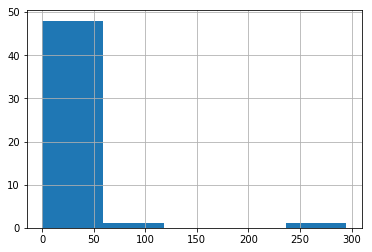

In [63]:
# let's visualize our total likes based on a histogram

import matplotlib.pyplot as plt
hyd_venues['total likes'].hist(bins=5)
plt.show()

In [64]:
print(np.percentile(hyd_venues['total likes'], 25))
print(np.percentile(hyd_venues['total likes'], 50))
print(np.percentile(hyd_venues['total likes'], 75))

0.0
0.0
2.0


In [65]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']==0:
        return 'poor'
    if s['total likes']<=5:
        return 'avg avg'
    if s['total likes']>=10:
        return 'great'

hyd_venues['total likes_cat']=hyd_venues.apply(conditions, axis=1)
hyd_venues


,id,name,lat,lng,categories,total likes,total likes_cat
0,4f9433d3e4b0949d21694780,Akbar Fast Food Restaurant,17.3945,78.4425,Indian Restaurant,1,avg avg
1,4c81163ad92ea093375a3d72,Shah Ghouse Cafe and Restaurant,17.3963,78.4251,Indian Restaurant,75,great
2,517bee0be4b055745975c517,Al Rabea Al Arabi Restaurant,17.3954,78.4326,Middle Eastern Restaurant,3,avg avg
3,50d1b77ee4b0d5316b4e0bff,Voulga Restaurant,17.3826,78.4658,Restaurant,0,poor
4,4bcee9d1cc8cd13a5efdc4cf,Paradise Restaurant,17.4418,78.4874,Hyderabadi Restaurant,295,great
5,5a21602775a6ea748fd77429,Nimrah Restaurant And Bakery,17.3926,78.4682,Restaurant,0,poor
6,5823557cda82023188157a2f,Grills restaurant,17.3861,78.4568,Financial or Legal Service,0,poor
7,5686bc36498ece24b0f97da8,Zoha Restaurant,17.3931,78.4576,Hyderabadi Restaurant,0,poor
8,5a1ade2ae96d0c5d8b3dc3da,Sri Anupama Family Restaurant,17.3848,78.4559,Andhra Restaurant,0,poor
9,4eb54b825c5c5a531ff0d6cd,Woodland Restaurant,17.4021,78.4858,Vegetarian / Vegan Restaurant,0,poor


In [66]:
# let's star the process for re-categorizing the categories

hyd_venues['categories'].unique()

array(['Indian Restaurant', 'Middle Eastern Restaurant', 'Restaurant',
       'Hyderabadi Restaurant', 'Financial or Legal Service',
       'Andhra Restaurant', 'Vegetarian / Vegan Restaurant',
       'Fast Food Restaurant', 'Albaik Restaurant', 'Asian Restaurant',
       'Food', 'Snack Place', 'Vashishta Restaurant', 'Afghan Restaurant',
       'Kebab Restaurant', 'Bakery', 'Café', 'Eagle bar & restaurant',
       'Bar', 'Chinese Restaurant', 'Swad restaurant',
       'Multicuisine Indian Restaurant'], dtype=object)

In [67]:
bars = ['pub', 'Eagle bar & restaurant', 'Bar', 'Dive Bar', 'Sports Bar']
other = ['Financial or Legal Service','Food']
indian_food = ['Restaurant','Indian Restaurant','Hyderabadi Restaurant','Andhra Restaurant','Vegetarian / Vegan Restaurant','Multicuisine Indian Restaurant','Vashishta Restaurant']
Cafe = ['Snack Place', 'Bakery', 'Café',]
american_food = ['Burger Joint','Fast Food Restaurant','American Restaurant']
chinese_food= ['Chinese Restaurant','Asian Restaurant']
eastern_food=['Middle Eastern Restaurant','Albaik Restaurant','Afghan Restaurant','Kebab Restaurant','Swad restaurant']

def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in indian_food:
        return 'indian food'
    if s['categories'] in Cafe:
        return 'Cafe'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in chinese_food:
        return 'chinese_food'
    if s['categories'] in eastern_food:
        return 'eastern_food'

hyd_venues['categories_new']=hyd_venues.apply(conditions2, axis=1)

In [68]:
hyd_venues

,id,name,lat,lng,categories,total likes,total likes_cat,categories_new
0,4f9433d3e4b0949d21694780,Akbar Fast Food Restaurant,17.3945,78.4425,Indian Restaurant,1,avg avg,indian food
1,4c81163ad92ea093375a3d72,Shah Ghouse Cafe and Restaurant,17.3963,78.4251,Indian Restaurant,75,great,indian food
2,517bee0be4b055745975c517,Al Rabea Al Arabi Restaurant,17.3954,78.4326,Middle Eastern Restaurant,3,avg avg,eastern_food
3,50d1b77ee4b0d5316b4e0bff,Voulga Restaurant,17.3826,78.4658,Restaurant,0,poor,indian food
4,4bcee9d1cc8cd13a5efdc4cf,Paradise Restaurant,17.4418,78.4874,Hyderabadi Restaurant,295,great,indian food
5,5a21602775a6ea748fd77429,Nimrah Restaurant And Bakery,17.3926,78.4682,Restaurant,0,poor,indian food
6,5823557cda82023188157a2f,Grills restaurant,17.3861,78.4568,Financial or Legal Service,0,poor,other
7,5686bc36498ece24b0f97da8,Zoha Restaurant,17.3931,78.4576,Hyderabadi Restaurant,0,poor,indian food
8,5a1ade2ae96d0c5d8b3dc3da,Sri Anupama Family Restaurant,17.3848,78.4559,Andhra Restaurant,0,poor,indian food
9,4eb54b825c5c5a531ff0d6cd,Woodland Restaurant,17.4021,78.4858,Vegetarian / Vegan Restaurant,0,poor,indian food


In [69]:
# one hot encoding
hyd_onehot = pd.get_dummies(hyd_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hyd_onehot['Name'] = hyd_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [hyd_onehot.columns[-1]] + list(hyd_onehot.columns[:-1])
hyd_onehot = hyd_onehot[fixed_columns]

hyd_onehot.head()

,Name,Cafe,american food,bars,chinese_food,eastern_food,indian food,other,avg avg,great,poor
0,Akbar Fast Food Restaurant,0,0,0,0,0,1,0,1,0,0
1,Shah Ghouse Cafe and Restaurant,0,0,0,0,0,1,0,0,1,0
2,Al Rabea Al Arabi Restaurant,0,0,0,0,1,0,0,1,0,0
3,Voulga Restaurant,0,0,0,0,0,1,0,0,0,1
4,Paradise Restaurant,0,0,0,0,0,1,0,0,1,0


# Clustring 

In [84]:
cluster_df = hyd_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 0, 2, 3, 2, 1, 2, 2, 2])

In [85]:
hyd_venues['label'] = kmeans.labels_
hyd_venues.head()

,id,name,lat,lng,categories,total likes,total likes_cat,categories_new,label
0,4f9433d3e4b0949d21694780,Akbar Fast Food Restaurant,17.3945,78.4425,Indian Restaurant,1,avg avg,indian food,0
1,4c81163ad92ea093375a3d72,Shah Ghouse Cafe and Restaurant,17.3963,78.4251,Indian Restaurant,75,great,indian food,3
2,517bee0be4b055745975c517,Al Rabea Al Arabi Restaurant,17.3954,78.4326,Middle Eastern Restaurant,3,avg avg,eastern_food,0
3,50d1b77ee4b0d5316b4e0bff,Voulga Restaurant,17.3826,78.4658,Restaurant,0,poor,indian food,2
4,4bcee9d1cc8cd13a5efdc4cf,Paradise Restaurant,17.4418,78.4874,Hyderabadi Restaurant,295,great,indian food,3


In [86]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hyd_venues['lat'], hyd_venues['lng'], hyd_venues['name'], hyd_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

## Analysis <a name="analysis"></a>

<h3>Cluster  1</h3>
Characterstics --> Poor quality food 

In [90]:
hyd_venues.loc[hyd_venues['label']==1]

,id,name,lat,lng,categories,total likes,total likes_cat,categories_new,label
6,5823557cda82023188157a2f,Grills restaurant,17.3861,78.4568,Financial or Legal Service,0,poor,other,1
15,5406d59f498e5c9379534db9,Venkey's Veg - A Multi Cuisine Restaurant,17.3946,78.4706,Fast Food Restaurant,0,poor,american food,1
17,51acc1b4498e59e850eaf731,Albaik Restaurant,17.3951,78.4715,Albaik Restaurant,0,poor,eastern_food,1
19,4df63e0bb61cbd3ec0246d14,Vaishnav's Restaurant,17.436,78.4609,Food,0,poor,other,1
20,4df074bad16486e86e503a2c,Hanky Panky Family Restaurant,17.3847,78.474,Fast Food Restaurant,0,poor,american food,1
21,4f69a816e4b039c9e5de7ab8,Agrawala Bakers And Restaurant,17.3865,78.476,Snack Place,0,poor,Cafe,1
23,548728f3498e54a2989b48ab,Kabul Darbar Restaurant,17.403,78.462,Afghan Restaurant,0,poor,eastern_food,1
26,51d286af498efb08f876c860,Seena Restaurant & Bakery,17.3817,78.475,Bakery,0,poor,Cafe,1
29,4dce4107d4c065592f7a13f2,Eagle bar & restaurant,17.4048,78.4643,Eagle bar & restaurant,0,poor,bars,1
30,5406c55c498e2804ff8ad973,Carnival Restaurant,17.4044,78.4621,Fast Food Restaurant,0,poor,american food,1


<h3>cluster 2</h3>
Characterstics --> Average quality food 

In [91]:
hyd_venues.loc[hyd_venues['label']==0]

,id,name,lat,lng,categories,total likes,total likes_cat,categories_new,label
0,4f9433d3e4b0949d21694780,Akbar Fast Food Restaurant,17.3945,78.4425,Indian Restaurant,1,avg avg,indian food,0
2,517bee0be4b055745975c517,Al Rabea Al Arabi Restaurant,17.3954,78.4326,Middle Eastern Restaurant,3,avg avg,eastern_food,0
12,52f8e44c498ea024d4f989e2,Dhruva Bar and Restaurant,17.4009,78.3869,Restaurant,2,avg avg,indian food,0
13,51d53e5e498e120a89aa3aab,Dwaraka (Veg Restaurant),17.4233,78.4543,Indian Restaurant,2,avg avg,indian food,0
14,4df9c2f6d4c064db03aa050d,"Venue, vegetarian Restaurant",17.393,78.4704,Indian Restaurant,1,avg avg,indian food,0
18,4ce8f32ae888f04d447c456b,Crystal Restaurant,17.4066,78.4963,Asian Restaurant,4,avg avg,chinese_food,0
24,575d8e7d498e5ed05b88906d,Bademiyan Kababs Restaurant,17.4031,78.46,Kebab Restaurant,3,avg avg,eastern_food,0
25,4e7f60e8be7b3ac644dbaa8b,Nasheman Restaurant,17.4039,78.4455,Indian Restaurant,2,avg avg,indian food,0
28,4f5371c7e4b0e14ed81472c3,Golden palace restaurant,17.3831,78.4384,Café,2,avg avg,Cafe,0
32,4df0f5b6d16486e86e5289e8,Narmada Bar & Restaurant,17.3911,78.4767,Bar,2,avg avg,bars,0


<h3>Cluster 3</h3>
Characterstics --> Great quality food 

In [89]:
hyd_venues.loc[hyd_venues['label']==3]

,id,name,lat,lng,categories,total likes,total likes_cat,categories_new,label
1,4c81163ad92ea093375a3d72,Shah Ghouse Cafe and Restaurant,17.3963,78.4251,Indian Restaurant,75,great,indian food,3
4,4bcee9d1cc8cd13a5efdc4cf,Paradise Restaurant,17.4418,78.4874,Hyderabadi Restaurant,295,great,indian food,3
11,513afb90e4b04d69fd7cc3c7,Okra Restaurant,17.4238,78.4873,Restaurant,20,great,indian food,3
16,4e4fb510b0fb088f3c1ece7f,Paradise Restaurant,17.4036,78.4528,Indian Restaurant,13,great,indian food,3
46,4e65c231e4cdf1e2c0b3e42a,Mohini Restaurant,17.4019,78.4762,Indian Restaurant,12,great,indian food,3
